# Autoenkodery

## Import + cuda

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from copy import copy

# for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats

%matplotlib inline
# %matplotlib widget
# set_matplotlib_formats('svg', 'pdf')
matplotlib.rcParams['lines.linewidth'] = 2.0
sns.reset_orig()
sns.set()

## torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Przygotowanie danych

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset, spliting it into a training and validation part
train_dataset = CIFAR10(root="data/", train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root="data/", train=False, transform=transform, download=True)

# Data loaders
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

# examples
def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(10, 10 + num)], dim=0)

Files already downloaded and verified
Files already downloaded and verified


## Budowanie autoenkodera
Generalnie autoenkoder zbudowany jest z enkodera, który mapuje wejściowe obrazki **x** w niskowymiarową przestrzeń ukrytą **z** oraz dekodera który odwraca tę operację i rekonstruuje wejście **x** z przestrzeni ukrytej **z**


### Stworzenie enkodera:

In [5]:
class Encoder(nn.Module):
    def __init__(
                self,
            num_input_channels: int,
            base_channel_size: int,
            latent_dim: int,
            act_fn: object = nn.GELU,
    ):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(
                num_input_channels, c_hid, kernel_size=(3,3), padding=1, stride=(2,2)
            ),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=(3,3), padding=1),
            act_fn(),
            nn.Conv2d(
                c_hid, 2 * c_hid, kernel_size=(3,3), padding=1, stride=(2,2)
            ),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=(3,3), padding=1),
            act_fn(),
            nn.Conv2d(
                2 * c_hid, 2 * c_hid, kernel_size=(3,3), padding=1, stride=(2,2)
            ),  # 8x8 => 4x4
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(2 * 16 * c_hid, latent_dim),
        )

    def forward(self, x):
        return self.net(x)

+ Uwaga - zauważmy, że w enkoderze nie ma ani dropoutu, ani BatchNormalization, ani Poolingu - te działania powodowałyby utratę informacji o obrazie.

### Dekoder
+ Dekoder jest lustrzanym odbiciem enkodera, w związku z tym musimy zastosować operację odwrotną do konwolucji, jest to splot transponowany:

In [6]:
conv_t = nn.ConvTranspose2d(1, 1, kernel_size=(2,2), bias=False)

In [7]:
torch.ones([1, 1, 3, 3])

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [8]:
conv_t.weight

Parameter containing:
tensor([[[[ 0.3638, -0.2051],
          [-0.2538, -0.4710]]]], requires_grad=True)

In [9]:
conv_t(torch.ones([1, 1, 3, 3]))

tensor([[[[ 0.3638,  0.1587,  0.1587, -0.2051],
          [ 0.1100, -0.5661, -0.5661, -0.6760],
          [ 0.1100, -0.5661, -0.5661, -0.6760],
          [-0.2538, -0.7248, -0.7248, -0.4710]]]],
       grad_fn=<SlowConvTranspose2DBackward>)

In [10]:
conv_t = nn.ConvTranspose2d(1, 1, kernel_size=(2,2), bias=False, output_padding=(1,1), padding=(1,1), stride=(2,2))
conv_t(torch.ones([1, 1, 3, 3]))

tensor([[[[ 0.4799,  0.3356,  0.4799,  0.3356,  0.4799],
          [ 0.3352, -0.1870,  0.3352, -0.1870,  0.3352],
          [ 0.4799,  0.3356,  0.4799,  0.3356,  0.4799],
          [ 0.3352, -0.1870,  0.3352, -0.1870,  0.3352],
          [ 0.4799,  0.3356,  0.4799,  0.3356,  0.4799]]]],
       grad_fn=<SlowConvTranspose2DBackward>)

+ A teraz sam dekoder:

In [11]:
class Decoder(nn.Module):
    def __init__(
            self,
            num_input_channels: int,
            base_channel_size: int,
            latent_dim: int,
            act_fn: object = nn.GELU,
    ):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(nn.Linear(latent_dim, 2 * 16 * c_hid), act_fn())
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                2 * c_hid,
                2 * c_hid,
                kernel_size=(3,3),
                output_padding=(1,1),
                padding=(1,1),
                stride=(2,2),
            ),
            # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=(3,3), padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                2 * c_hid, c_hid, kernel_size=(3,3), output_padding=(1,1), padding=(1,1), stride=(2,2)
            ),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=(3,3), padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                c_hid,
                num_input_channels,
                kernel_size=(3,3),
                output_padding=(1,1),
                padding=(1,1),
                stride=(2,2),
            ),
            # 16x16 => 32x32
            nn.Tanh(),  # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x_inp):
        x_inp = self.linear(x_inp)
        x_inp = x_inp.reshape(x_inp.shape[0], -1, 4, 4)
        x_inp = self.net(x_inp)
        return x_inp

## Łączenie enkodera z dekoderem

In [12]:
class Autoencoder(nn.Module):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class: object = Encoder,
                 decoder_class: object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 32,
                 height: int = 32):
        super().__init__()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

## Trenowanie modelu 
Jako funkcję straty wykorzystamy MSE pomiędzy oryginalnymi, a rekonstruowanymi pikselami, co jest problematyczne.

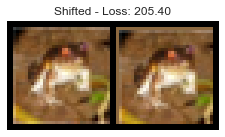

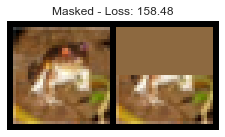

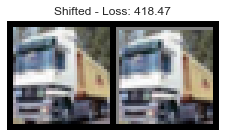

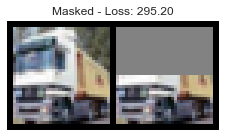

In [13]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss_mse = F.mse_loss(img1, img2, reduction="sum")
    # Plot images for visual comparison
    grid_imgs = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, range=(-1, 1))
    grid_imgs = grid_imgs.permute(1, 2, 0)
    plt.figure(figsize=(4, 2))
    plt.title(f"{title_prefix} Loss: {loss_mse.item():4.2f}")
    plt.imshow(grid_imgs)
    plt.axis('off')
    plt.show()


for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(dim=[1, 2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:, :1, :] = img_mean
    img_shifted[:, :, :1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:, :img_masked.shape[1] // 2, :] = img_mean
    compare_imgs(img, img_masked, "Masked -")

+ Inne funkcje straty dla autoenkoderów:
    + Adwersarialna funkcja straty (na następnych zajęciach).
    + Funkcje straty w oparciu o transformaty (np. Laplacian piramid loss).

### Uczenie - przestrzeń ukryta 128-wymiarowa:

In [14]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=128, encoder_class=Encoder, decoder_class=Decoder).to(device)

In [15]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)  # do zmniejszania learning rate

In [25]:
num_epochs = 100
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out = autoencoder(x)
        loss = criterion(out, x)
        losses_epoch.append(loss.item())
        loss.backward()  # backward pass (compute parameter updates)
        optimizer.step()  # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
    #     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x = x.to(device)
        out = autoencoder(x)
        L1_list.append(torch.mean(torch.abs(out - x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 94103.15544642857, test L1 = 0.21106969751417637
Epoch 1 loss 50623.20185267857, test L1 = 0.16443871669471263
Epoch 2 loss 35766.46087053572, test L1 = 0.1489855721592903
Epoch 3 loss 32032.24457589286, test L1 = 0.14262050949037075
Epoch 4 loss 29844.783761160714, test L1 = 0.1387275904417038
Epoch 5 loss 28441.70703125, test L1 = 0.13506373353302478
Epoch 6 loss 26763.042700892856, test L1 = 0.128915380127728
Epoch 7 loss 24639.5415625, test L1 = 0.12371975053101777
Epoch 8 loss 23096.067801339286, test L1 = 0.12481715120375156
Epoch 9 loss 22013.248939732144, test L1 = 0.11693911515176296
Epoch 10 loss 21052.673482142858, test L1 = 0.11473167687654495
Epoch 11 loss 20093.16059151786, test L1 = 0.11236325185745955
Epoch 12 loss 19213.184564732142, test L1 = 0.1093157634139061
Epoch 13 loss 18477.922566964287, test L1 = 0.10741800479590893
Epoch 14 loss 17927.785597098213, test L1 = 0.10577276349067688
Epoch 15 loss 17430.472137276785, test L1 = 0.1048580227419734
Epoch 

In [28]:
# torch.save(autoencoder.state_dict(),"models/autoencoder_128")

In [29]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=128, encoder_class=Encoder, decoder_class=Decoder).to(device)
autoencoder.load_state_dict(torch.load("models/autoencoder_128"))

<All keys matched successfully>

In [30]:
def visualize_reconstructions(model, input_images, device_cuda):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_images.to(device_cuda))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    images = torch.stack([input_images, reconst_imgs], dim=1).flatten(0, 1)
    grid_images = torchvision.utils.make_grid(images, nrow=4, normalize=True, range=(-1, 1))
    grid_images = grid_images.permute(1, 2, 0)
    if len(input_images) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Reconstructions")
    plt.imshow(grid_images)
    plt.axis('off')
    plt.show()

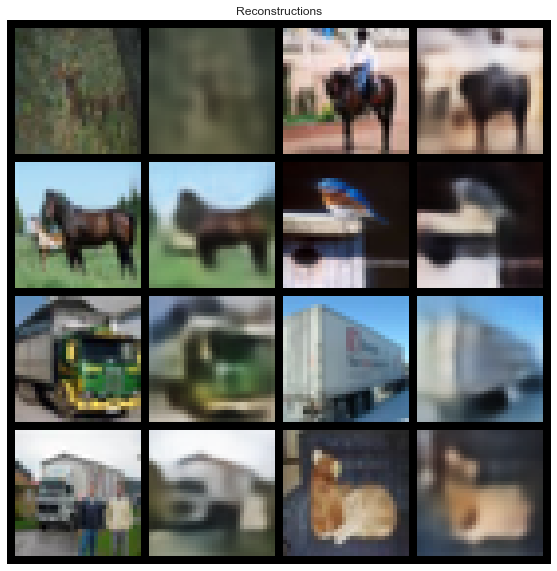

In [31]:
input_imgs = get_train_images(8)
visualize_reconstructions(autoencoder, input_imgs, device)

### Większa przestrzeń ukryta - 256 wymiarowa:

In [32]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=256, encoder_class=Encoder, decoder_class=Decoder).to(device)

In [33]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [38]:
num_epochs = 100
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out = autoencoder(x)
        loss = criterion(out, x)
        losses_epoch.append(loss.item())
        loss.backward()  # backward pass (compute parameter updates)
        optimizer.step()  # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
    #     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x = x.to(device)
        out = autoencoder(x)
        L1_list.append(torch.mean(torch.abs(out - x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 92086.68316964286, test L1 = 0.20774692185223104
Epoch 1 loss 47287.848125, test L1 = 0.15884058065712453
Epoch 2 loss 33981.35224330357, test L1 = 0.14500367306172848
Epoch 3 loss 30470.885926339284, test L1 = 0.13902576975524425
Epoch 4 loss 28117.392578125, test L1 = 0.13333810567855836
Epoch 5 loss 26246.913973214287, test L1 = 0.1273984083905816
Epoch 6 loss 24249.26978794643, test L1 = 0.12163779400289058
Epoch 7 loss 22367.17606026786, test L1 = 0.12226786110550165
Epoch 8 loss 21093.906160714287, test L1 = 0.11455677524209022
Epoch 9 loss 19778.962723214285, test L1 = 0.1099776953458786
Epoch 10 loss 18670.125948660716, test L1 = 0.106001085229218
Epoch 11 loss 17589.578671875, test L1 = 0.10490016900002956
Epoch 12 loss 16788.8225390625, test L1 = 0.10175847690552473
Epoch 13 loss 16140.563883928571, test L1 = 0.10044358316808939
Epoch 14 loss 15499.815474330357, test L1 = 0.097499805316329
Epoch 15 loss 14851.3584375, test L1 = 0.0960390917956829
Epoch 16 loss 14

In [39]:
# torch.save(autoencoder.state_dict(),"models/autoencoder_256")

In [40]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=256, encoder_class=Encoder, decoder_class=Decoder).to(device)
autoencoder.load_state_dict(torch.load("models/autoencoder_256"))

<All keys matched successfully>

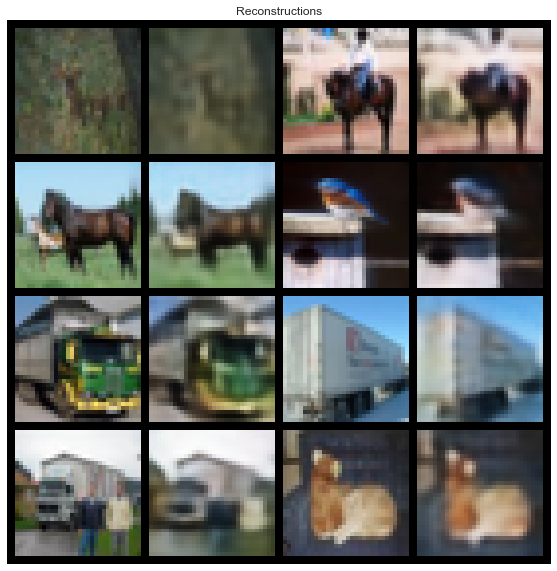

In [41]:
input_imgs = get_train_images(8)
visualize_reconstructions(autoencoder, input_imgs, device)

### 512-wymiarowa przestrzeń ukryta:

In [42]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=512, encoder_class=Encoder, decoder_class=Decoder).to(device)

In [43]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [45]:
num_epochs = 100
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out = autoencoder(x)
        loss = criterion(out, x)
        losses_epoch.append(loss.item())
        loss.backward()  # backward pass (compute parameter updates)
        optimizer.step()  # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
    #     if n % 10 == 0:
    for x, _ in iter(test_loader):
        x = x.to(device)
        out = autoencoder(x)
        L1_list.append(torch.mean(torch.abs(out - x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 95843.97040178571, test L1 = 0.2121255375444889
Epoch 1 loss 47558.84732142857, test L1 = 0.15992754586040975
Epoch 2 loss 34187.56582589286, test L1 = 0.14473175257444382
Epoch 3 loss 29698.52166294643, test L1 = 0.1348988886922598
Epoch 4 loss 26649.71900669643, test L1 = 0.1272971574217081
Epoch 5 loss 23688.012779017856, test L1 = 0.12041608784347772
Epoch 6 loss 21489.004252232142, test L1 = 0.1150378979742527
Epoch 7 loss 19518.016841517856, test L1 = 0.10861189868301153
Epoch 8 loss 17889.035301339285, test L1 = 0.10482715647667647
Epoch 9 loss 16709.691869419643, test L1 = 0.10094268582761287
Epoch 10 loss 15613.549324776786, test L1 = 0.09764147680252791
Epoch 11 loss 14635.4725390625, test L1 = 0.09419500138610601
Epoch 12 loss 13901.079012276785, test L1 = 0.09215530790388585
Epoch 13 loss 13249.234012276786, test L1 = 0.0903257479891181
Epoch 14 loss 12664.548459821428, test L1 = 0.08834568150341511
Epoch 15 loss 12144.378091517858, test L1 = 0.0867894165217876

In [46]:
# torch.save(autoencoder.state_dict(),"models/autoencoder_512")

In [47]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=512, encoder_class=Encoder, decoder_class=Decoder).to(device)
autoencoder.load_state_dict(torch.load("models/autoencoder_512"))

<All keys matched successfully>

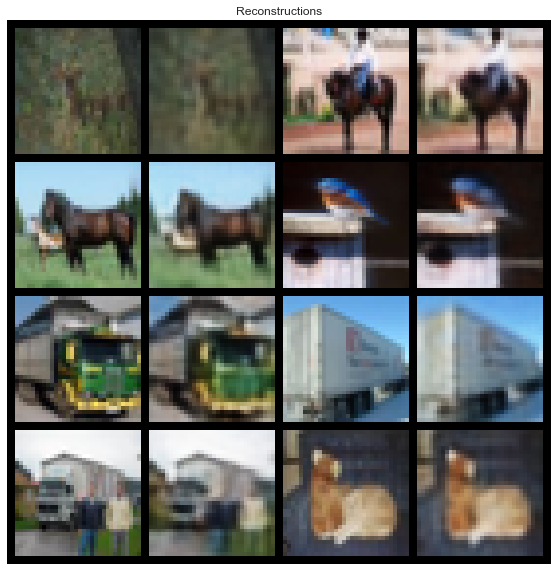

In [48]:
input_imgs = get_train_images(8)
visualize_reconstructions(autoencoder, input_imgs, device)

### Porównanie:

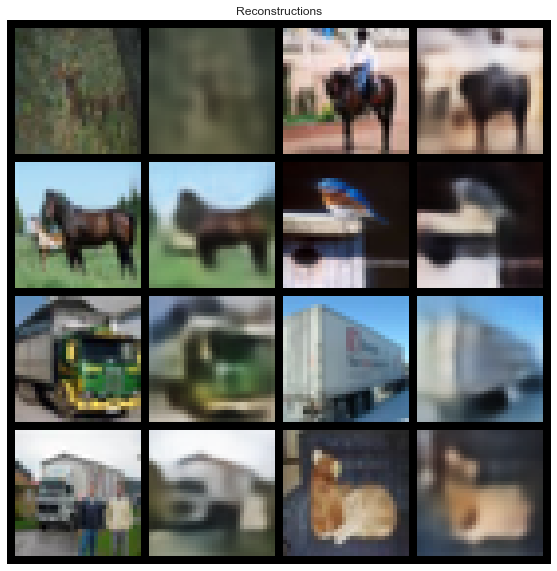

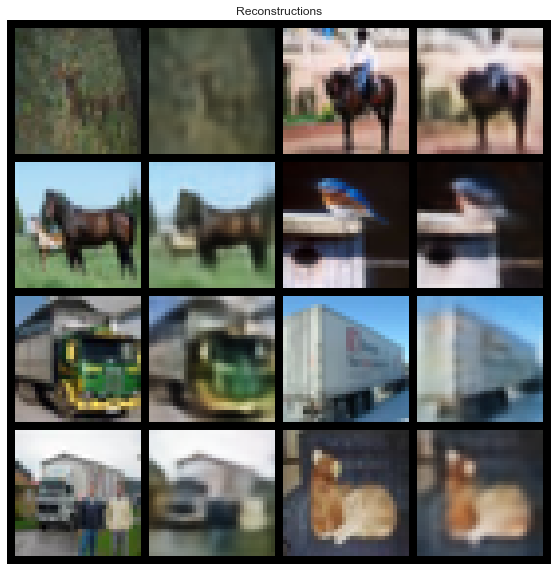

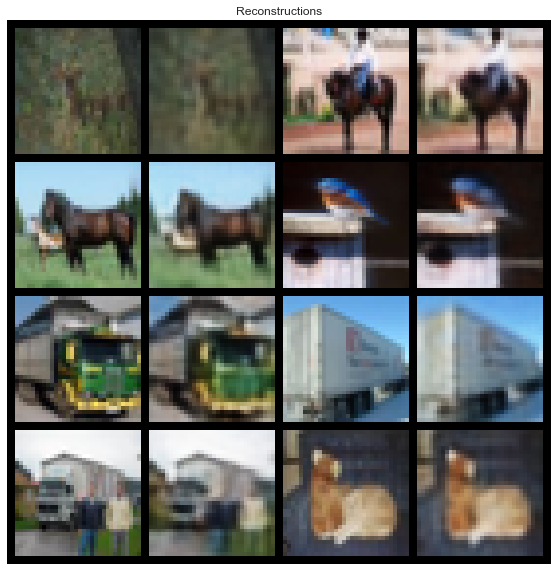

In [49]:
input_imgs = get_train_images(8)
for latent in [128, 256, 512]:
    autoencoder = Autoencoder(base_channel_size=32, latent_dim=latent, encoder_class=Encoder, decoder_class=Decoder).to(
        device)
    autoencoder.load_state_dict(torch.load(f"models/autoencoder_{latent}"))
    visualize_reconstructions(autoencoder, input_imgs, device)

+ Widzimy, że nie ma dużej różnicy między przestrzenią ukrytą 256-wymiarową a 512-wymiarową - wybierzmy tą mniejszą do dalszych obliczeń:

In [50]:
latent = 256
autoencoder = Autoencoder(base_channel_size=32, latent_dim=latent, encoder_class=Encoder, decoder_class=Decoder).to(
    device)
autoencoder.load_state_dict(torch.load(f"models/autoencoder_{latent}"))

<All keys matched successfully>

### Problemy ze skutecznością rekonstrukcji.
+ Nie jesteśmy w stanie wszystkie rekonstruować z podobną skutecznością:
    + Mamy problem z krawędziami.
    + Mamy problem ze zróżnicowanymi kolerami.

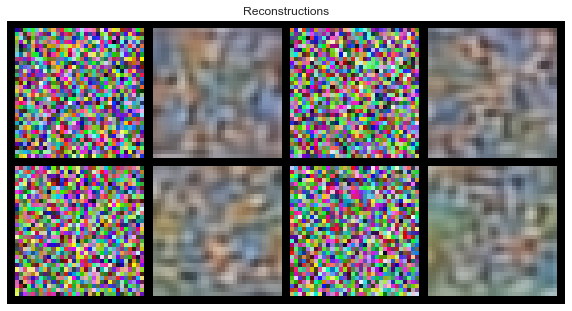

In [51]:
rand_imgs = torch.rand(4, 3, 32, 32) * 2 - 1
visualize_reconstructions(autoencoder, rand_imgs, device)

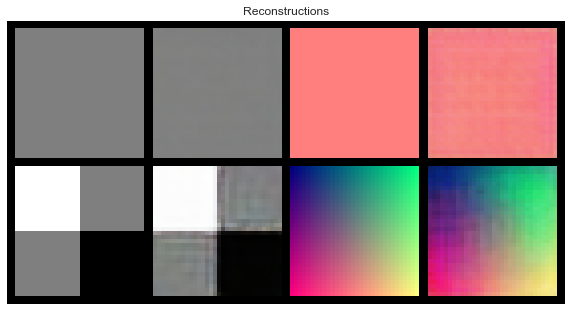

In [52]:
plain_imgs = torch.zeros(4, 3, 32, 32)

# Single color channel
plain_imgs[1, 0] = 1
# Checkboard pattern
plain_imgs[2, :, :16, :16] = 1
plain_imgs[2, :, 16:, 16:] = -1
# Color progression
xx, yy = torch.meshgrid(torch.linspace(-1, 1, 32), torch.linspace(-1, 1, 32))
plain_imgs[3, 0, :, :] = xx
plain_imgs[3, 1, :, :] = yy

visualize_reconstructions(autoencoder, plain_imgs, device)

## Generowanie nowych obrazów
Skoro mamy reprezentacje ukryte, to możemy wylosować dowolny wektor i odtworzyć nowy obrazek?

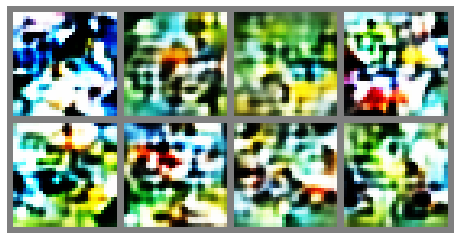

In [53]:
latent_vectors = torch.randn(8, latent, device=device)
with torch.no_grad():
    imgs = autoencoder.decoder(latent_vectors)
    imgs = imgs.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1, 1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8, 5))
plt.imshow(grid)
plt.axis('off')
plt.show()


+ Nie jestesmy w stanie tego zrobić - z niemal zerowym prawdopodobieństwem trafimy w miejsce w przestrzeni ukrytej gdzie znajduje się jeden z obrazów, na jakim miał miejsce trening.
+ Sposób na poprawę - użycie rozkładów prawdopodobieństw tak, aby o konkretnych obrazkach na których jest wykonywany trening, mówić w kontekście ich sąsiedztwa. Wtedy gdy wylosujemy punkt z sąsiedztwa danego obrazka, odtwarzamy ten obrazek, a przynajmniej jego interpolacje z innym obrazkiem (jeśli sąsiedztwa się pokrywają).

## Przestrzeń ukryta autoenkodera

+ Nie jestesmy w stanie generować obrazków, ale możemy pokazywać najbardziej podobne do siebie - dzięki odległości między dwoma obrazkami (a dokładnie odpowiadającymi im punktami w przestrzeni ukrytej).

In [54]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    labels = []
    for data_image, data_label in data_loader:
        with torch.no_grad():
            z = model.encoder(data_image.to(device))
        img_list.append(data_image)
        embed_list.append(z)
        labels.append(data_label)
    return torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels, dim=0)


train_img_embeds = embed_imgs(autoencoder, train_loader)
test_img_embeds = embed_imgs(autoencoder, test_loader)

In [55]:
def find_similar_images(query_img, query_z, key_embeds, k=8):
    # Find closest k images. We use the euclidean distance here but other like cosine distance can also be used.
    distance = torch.cdist(query_z[None, :], key_embeds[1], p=2)
    distance = distance.squeeze(dim=0)
    distance, indices = torch.sort(distance)
    # Plot K closest images
    images_to_display = torch.cat([query_img[None], key_embeds[0][indices[:k]]], dim=0)
    grid_images = torchvision.utils.make_grid(images_to_display, nrow=k + 1, normalize=True, range=(-1, 1))
    grid_images = grid_images.permute(1, 2, 0)
    plt.figure(figsize=(12, 3))
    plt.imshow(grid_images)
    plt.axis('off')
    plt.show()

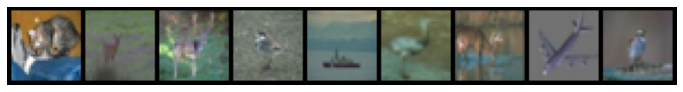

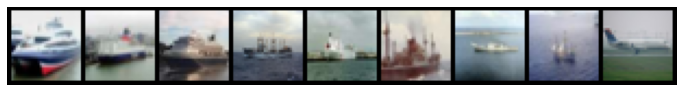

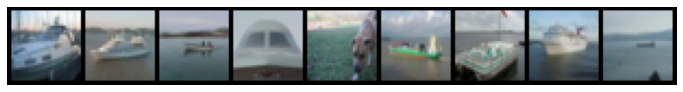

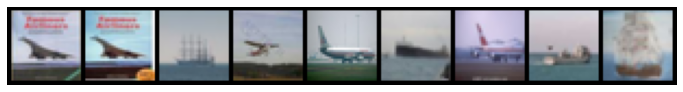

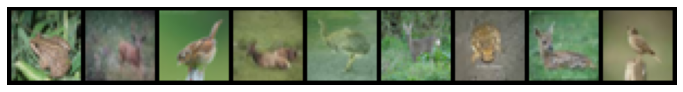

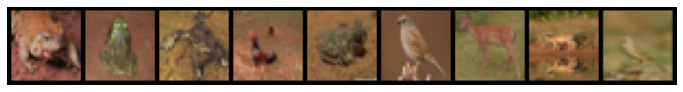

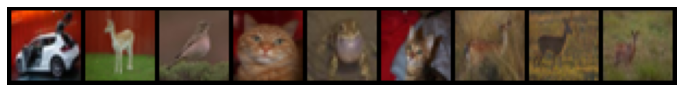

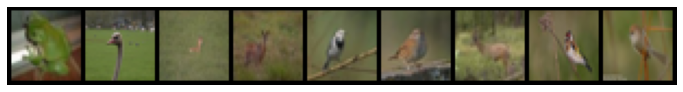

In [56]:
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)

### Wizualizacja przestrzeni ukrytej:

+ Służy do tego UMAP - realizuje przekształcenie wielowymiarowej przestrzeni do 2-wymiarowej.
+ Wybieramy metrykę cosinusową - metryka ta lepiej obrazuje zależności między obrazami.

In [57]:
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

umap = umap.UMAP(metric="cosine", n_neighbors=100)

In [58]:
train_embedded = umap.fit_transform(train_img_embeds[1][:5000].cpu())

In [59]:
data = pd.DataFrame(train_embedded)

In [60]:
data["label"] = train_img_embeds[2][:5000].cpu().numpy()

+ Możemy teraz zobrazować rozkład konkretnych kategorii obrazów w przestrzeni ukrytej.

<AxesSubplot:xlabel='0', ylabel='1'>

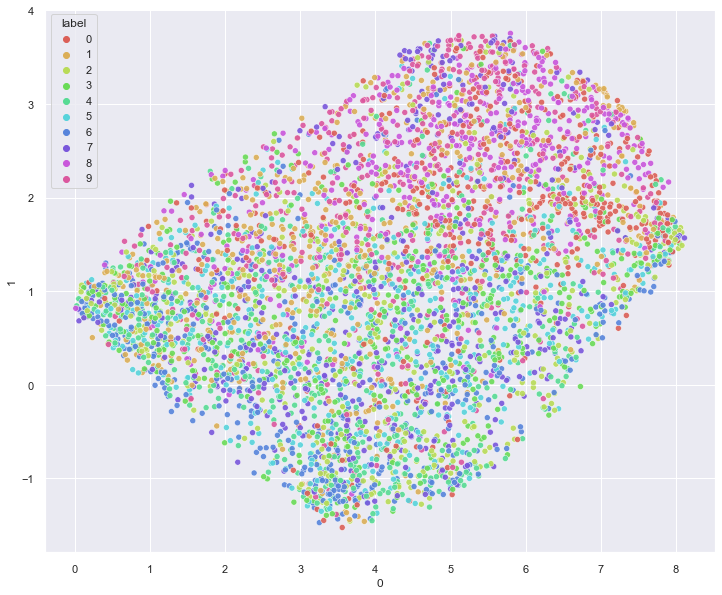

In [61]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.9
)

+ Możemy również w ramach tej przestrzeni pokazać obrazki reprezentujące konkretne kategorie obrazków:

In [62]:
examples = []
examples_locations = []
for i in np.random.randint(0, 5000, 40):
    examples.append(train_img_embeds[0][i].cpu().numpy())
    examples_locations.append(data.iloc[i])

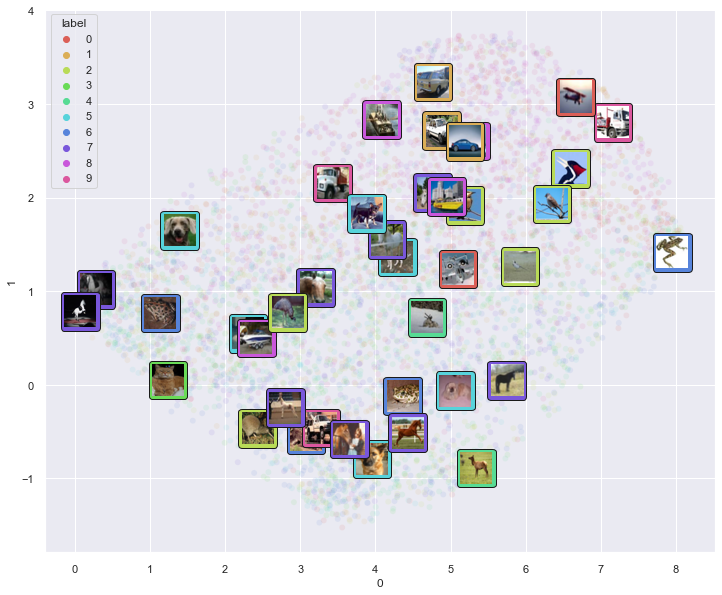

In [63]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.1
)
for location, example in zip(examples_locations, examples):
    x, y = location[0], location[1]
    label = int(location["label"])
    ab = AnnotationBbox(OffsetImage(np.swapaxes(np.swapaxes(example, 0, 1), 1, 2) / 2 + 0.5, zoom=1), (x, y),
                        frameon=True,
                        bboxprops=dict(facecolor=sns.color_palette("hls", 10)[label], boxstyle="round"))
    ax.add_artist(ab)
plt.show()

### Wykrywanie nietypowych obrazków w oparciu o reprezentacje:
+ Możemy zobaczyć jakiego rodzaju obrazki są nietypowe jak na swoją reprezentację (klasę do której należą):

In [64]:
dist = torch.cdist(train_img_embeds[1].cpu(), train_img_embeds[1].cpu(), p=2)

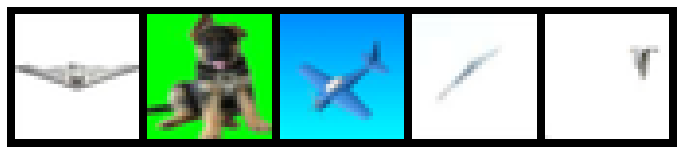

In [65]:
outliers = torch.sort(dist.sum(0))[1][-5:]
imgs_to_display = train_img_embeds[0][outliers]
grid = torchvision.utils.make_grid(imgs_to_display, normalize=True, range=(-1, 1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12, 3))
plt.axis('off')
plt.imshow(grid)

+ A także sprawdzić jakie są uważane za typowe:

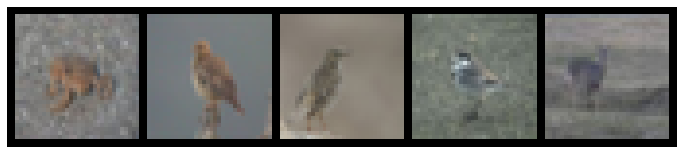

In [66]:
most_usual = torch.sort(dist.sum(0))[1][:5]
imgs_to_display = train_img_embeds[0][most_usual]
grid = torchvision.utils.make_grid(imgs_to_display, normalize=True, range=(-1, 1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12, 3))
plt.axis('off')
plt.imshow(grid)

## Odszumianie za pomocą autoenkodera
+ Przykład ze zbiorem MNIST:

In [91]:
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_test_data = torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

In [92]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

### Dodajemy dodatkowe obrazki z szumem:

In [93]:
images_with_noise = mnist_test_data.data.float() + torch.randn_like(mnist_test_data.data.float()) * 0.3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


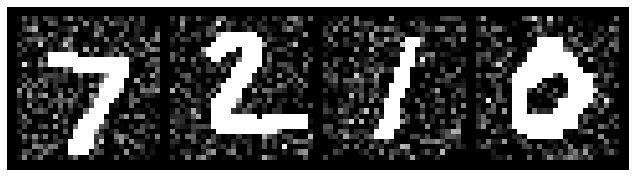

In [94]:
grid = torchvision.utils.make_grid(images_with_noise[:4].unsqueeze(1))  #, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12, 3))
plt.axis('off')
plt.imshow(grid)

+ A tak wyglądają obrazki bez szumu w dataset'cie:

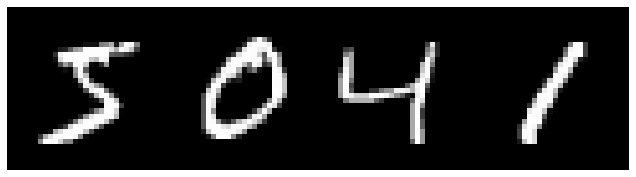

In [95]:
grid = torchvision.utils.make_grid(mnist_data.data[:4].unsqueeze(1))  #, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12, 3))
plt.axis('off')
plt.imshow(grid)

### Stwórzmy autoenkoder

In [96]:
class MNISTAutoencoder(nn.Module):
    def __init__(self):
        super(MNISTAutoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=(3,3), padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=(3,3), padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=(3,3), padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=(3,3), padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=(3,3), stride=(2,2))
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=(3,3), stride=(2,2))
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=(2,2), stride=(2,2))
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=(2,2), stride=(2,2))
        self.out = nn.Conv2d(64, 1, kernel_size=(3,3), padding=1)

    def forward(self, x_inp):
        # encode
        x_inp = F.relu(self.enc1(x_inp))
        x_inp = self.pool(x_inp)
        x_inp = F.relu(self.enc2(x_inp))
        x_inp = self.pool(x_inp)
        x_inp = F.relu(self.enc3(x_inp))
        x_inp = self.pool(x_inp)
        x_inp = F.relu(self.enc4(x_inp))
        x_inp = self.pool(x_inp)  # the latent space representation

        # decode
        x_inp = F.relu(self.dec1(x_inp))
        x_inp = F.relu(self.dec2(x_inp))
        x_inp = F.relu(self.dec3(x_inp))
        x_inp = F.relu(self.dec4(x_inp))
        x_inp = torch.sigmoid(self.out(x_inp))
        return x_inp


net = MNISTAutoencoder().to(device)
print(net)

MNISTAutoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [97]:
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Nauczmy autoenkoder na zbiorze czystym:

In [98]:
train_loss = []
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data  # we do not need the image labels
        img = img.to(device)
        optimizer.zero_grad()
        outputs = net(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch + 1, epochs, loss))

Epoch 1 of 10, Train Loss: 0.062
Epoch 2 of 10, Train Loss: 0.043
Epoch 3 of 10, Train Loss: 0.040
Epoch 4 of 10, Train Loss: 0.039
Epoch 5 of 10, Train Loss: 0.038
Epoch 6 of 10, Train Loss: 0.038
Epoch 7 of 10, Train Loss: 0.037
Epoch 8 of 10, Train Loss: 0.037
Epoch 9 of 10, Train Loss: 0.036
Epoch 10 of 10, Train Loss: 0.036


#### Porównajmy sobie jak działa nasz autoenkoder na obrazach zwyklych a jak na zaszumionych.
+ Na początek jak wyglądają obrazki:

In [99]:
imgs, _ = next(iter(train_loader))

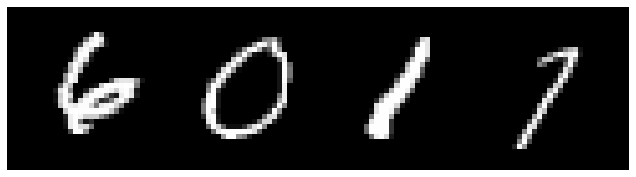

In [100]:
grid = torchvision.utils.make_grid(imgs[:4])  #, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12, 3))
plt.axis('off')
plt.imshow(grid)

+ Jak są odtwarzane:

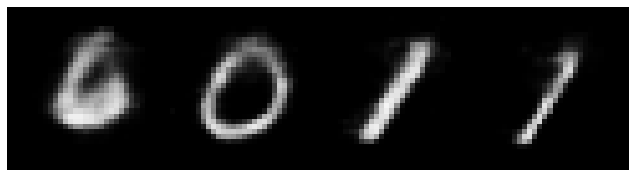

In [101]:
with torch.no_grad():
    examples = net(imgs[:4].to(device)).cpu()
    grid = torchvision.utils.make_grid(examples)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12, 3))
    plt.axis('off')
    plt.imshow(grid)

+ Jak są odtwarzane z wersji zaszumionej:

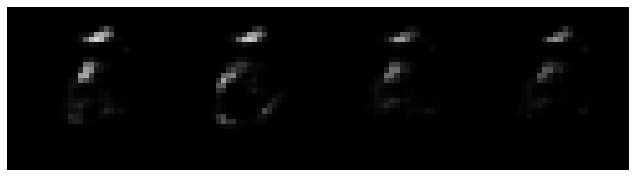

In [102]:
with torch.no_grad():
    examples = net((imgs[:4] + torch.randn_like(imgs[:4]) * 0.5).to(device)).cpu()
    grid = torchvision.utils.make_grid(examples)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12, 3))
    plt.axis('off')
    plt.imshow(grid)

### Poprawmy:

In [103]:
train_loss = []
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data  # we do not need the image labels
        img = img.to(device)
        optimizer.zero_grad()
        outputs = net(img + torch.randn_like(img.float())) # <--- change - now model will also learn at noised numbers
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch + 1, epochs, loss))

Epoch 1 of 10, Train Loss: 0.052
Epoch 2 of 10, Train Loss: 0.048
Epoch 3 of 10, Train Loss: 0.047
Epoch 4 of 10, Train Loss: 0.046
Epoch 5 of 10, Train Loss: 0.046
Epoch 6 of 10, Train Loss: 0.046
Epoch 7 of 10, Train Loss: 0.045
Epoch 8 of 10, Train Loss: 0.045
Epoch 9 of 10, Train Loss: 0.045
Epoch 10 of 10, Train Loss: 0.045


#### Porównanie:
+ Odtwarzanie normalnych:

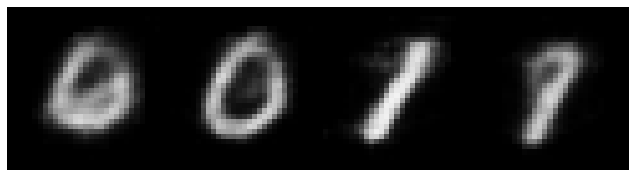

In [104]:
with torch.no_grad():
    examples = net(imgs[:4].to(device)).cpu()
    grid = torchvision.utils.make_grid(examples)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12, 3))
    plt.axis('off')
    plt.imshow(grid)

+ Odtwarzanie zaszumionych:

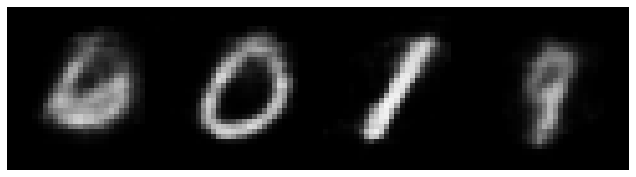

In [105]:
with torch.no_grad():
    examples = net((imgs[:4] + torch.randn_like(imgs[:4]) * 0.5).to(device)).cpu()
    grid = torchvision.utils.make_grid(examples)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12, 3))
    plt.axis('off')
    plt.imshow(grid)

+ Widać znaczącą poprawę :)

## Autoenkoder prostujący obrazki (o ile tego wymagają)
+ Zniekształcenie poprzez przerzucenie część obrazków za pomocą torch.transpose

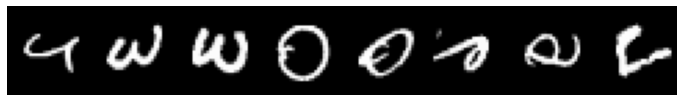

In [82]:
grid = torchvision.utils.make_grid(torch.transpose(imgs[10:18], 2, 3))  #, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(12, 3))
plt.axis('off')
plt.imshow(grid)

+ Uczenie:

In [83]:
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_test_data = torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())

In [84]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

In [85]:
net = MNISTAutoencoder().to(device)
print(net)

MNISTAutoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [86]:
criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [87]:
train_loss = []
epochs = 30
for epoch in range(epochs):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        # at first learning on classic dataset
        optimizer.zero_grad()
        outputs1 = net(img)
        loss = criterion(outputs1, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # at second learning on transposed dataset
        optimizer.zero_grad()
        outputs2 = net(torch.transpose(img, 2, 3))
        loss = criterion(outputs2, img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch + 1, epochs, loss))
    scheduler.step()

Epoch 1 of 30, Train Loss: 0.109
Epoch 2 of 30, Train Loss: 0.080
Epoch 3 of 30, Train Loss: 0.077
Epoch 4 of 30, Train Loss: 0.074
Epoch 5 of 30, Train Loss: 0.073
Epoch 6 of 30, Train Loss: 0.072
Epoch 7 of 30, Train Loss: 0.071
Epoch 8 of 30, Train Loss: 0.070
Epoch 9 of 30, Train Loss: 0.070
Epoch 10 of 30, Train Loss: 0.069
Epoch 11 of 30, Train Loss: 0.069
Epoch 12 of 30, Train Loss: 0.068
Epoch 13 of 30, Train Loss: 0.068
Epoch 14 of 30, Train Loss: 0.067
Epoch 15 of 30, Train Loss: 0.067
Epoch 16 of 30, Train Loss: 0.067
Epoch 17 of 30, Train Loss: 0.067
Epoch 18 of 30, Train Loss: 0.066
Epoch 19 of 30, Train Loss: 0.066
Epoch 20 of 30, Train Loss: 0.066
Epoch 21 of 30, Train Loss: 0.066
Epoch 22 of 30, Train Loss: 0.065
Epoch 23 of 30, Train Loss: 0.065
Epoch 24 of 30, Train Loss: 0.065
Epoch 25 of 30, Train Loss: 0.065
Epoch 26 of 30, Train Loss: 0.065
Epoch 27 of 30, Train Loss: 0.065
Epoch 28 of 30, Train Loss: 0.064
Epoch 29 of 30, Train Loss: 0.064
Epoch 30 of 30, Train L

+ Test:

In [88]:
mnist_test_data = torchvision.datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
mnist_test_transformed = copy(mnist_test_data)
mnist_test_transformed.data = torch.transpose(mnist_test_transformed.data, 1, 2)
batch_size = 20
test_full_dataset = torch.utils.data.ConcatDataset([mnist_test_data, mnist_test_transformed])

mnist_test_loader = torch.utils.data.DataLoader(test_full_dataset, batch_size=batch_size, shuffle=True)

+ Wejscie:

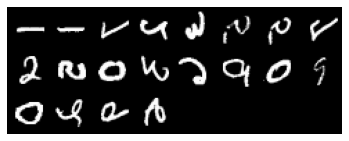

In [89]:
images_test, _ = next(iter(mnist_test_loader))
grid = torchvision.utils.make_grid(images_test[:])  #, normalize=True, range=(-1,1))
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(grid)

+ Wyjście sieci:

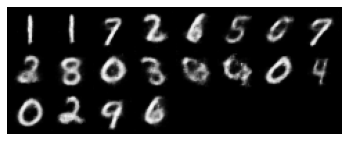

In [90]:
with torch.no_grad():
    examples = net(images_test.to(device)).cpu()
    grid = torchvision.utils.make_grid(examples)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(grid)